# Analyzis of House Sales Prices in Érd, Hungary

##  1. Introduction/Business Problem

I live in Hungary (a small country in Eastern Europe with population of 9.5 million), in a small city near the capital, called Érd. In the last 10 years, this city has developed a lot. Thanks to it more and more people are moving here, who want more peaceful and clearer environment around them. The population of Érd has grown by 12% in 10 years, and the population density is 1140 people per square kilometer (the area of Érd is 60 square kilometer).

The city is just 20km from the capital, that's why 60% of the inhabitants works in the capital (commuter). The rapid growth of the population has led to the construction of housing in large numbers. In the last 10 years the number of dwellings increased by 9%. This development attracts investors and entrepreneurs, so more and more shops, stores, restaurants are opening.

Who want to move to Érd, try to find a place for their new home at the best price, but they also want easy access to transport and social places. I live in Érd for 2 years, and I remember it was very hard to gather all of these informations and find a good place near to railway or bus station, near to school adn so on. Unfortunately there is not such a comparision web page, therefore **in my project I will show a map about Érd and its districts, the real estate prices in these districts and make an analyzis of the connection to the venue density. Finally I cluster the city based on the venue density and visualize it.**

## 2. Data

To solve the problem I needed the following data:
* the boroughs of Érd and their coordinates
* the average sales price for houses in each borough
* the venues in each district

I used the following applications and sources:
* I got the average real estate sales price from the page of National Statistical Office, I cleaned the data and reduced it to city of Érd. 
* I used Google Map to get the center coordinates of each district.
* I used Forsquare API to get the most common venues of given district.
* I used Folium to visualize the average price in each district on map.
* I used unsupervised learning K-means algorithm to cluster the boroughs.

## 3. Methodology

<p>Érd is a small town in Hungary near to the capital Budapest. As you see in the map, it has a border with Budapest, so it is like a suburb.</p>

<img src="Erd.jpg">

In [1]:
import pandas as pd # import pandas to handle dataframes from files

Érd has 11 districts, and I found their latitude and longitude coordinates with the help of Google Maps Nearby function. I wrote the values into an excel file, then I made a csv file out of it, that pandas can handle. Here is my final table.

In [2]:
coordinates = pd.read_csv('District.csv')
coordinates

,Borough,Latitude,Longitude
0,Ófalu,47.3617,18.9315
1,Újfalu,47.3740,18.9268
2,Tisztviselőtelep,47.3686,18.9050
3,Újtelep,47.3719,18.8881
4,Tusculanum,47.3838,18.9093
5,Postástelep,47.3929,18.9159
6,Érdliget,47.3885,18.9346
7,Parkváros,47.4133,18.8960
8,Dombosváros,47.3940,18.8888
9,Vincellér,47.4006,18.9117


I downloaded the average real estate sales prices for Budapest and its surrounding cities from web page of National Statistical Office in Hungary, I dropped the unnecessary coloumns and rows, so the data show the average price only for the boroughs of Érd.

In [3]:
price = pd.read_csv('Averageprice.csv')
price

,Borough,Price
0,Újfalu,43660
1,Tisztviselőtelep,54400
2,Újtelep,44490
3,Tusculanum,70960
4,Dombosváros,56610
5,Vincellér,55230
6,Parkváros,60460
7,Fenyves-Parkváros,71170
8,Ófalu,40140
9,Érdliget,63970


As you can see, there is a big difference among the average prices, the lowest prices are in Ófalu, Újfalu and Újtelep - these are the oldest parts of the town near to the river Danube.

Thereafter I merged the two table into one, because I want to show the boroughs and their average prices in a map.

In [4]:
erd_price = pd.merge(price, coordinates, how='left', on='Borough')
erd_price

,Borough,Price,Latitude,Longitude
0,Újfalu,43660,47.3740,18.9268
1,Tisztviselőtelep,54400,47.3686,18.9050
2,Újtelep,44490,47.3719,18.8881
3,Tusculanum,70960,47.3838,18.9093
4,Dombosváros,56610,47.3940,18.8888
5,Vincellér,55230,47.4006,18.9117
6,Parkváros,60460,47.4133,18.8960
7,Fenyves-Parkváros,71170,47.4216,18.8733
8,Ófalu,40140,47.3617,18.9315
9,Érdliget,63970,47.3885,18.9346


In [5]:
import folium # this package can help to show the map

In [6]:
# folium marker can work only with strings, so I had to convert the datatype of Price column
erd_price[['Price']] = erd_price[['Price']].astype("str") 

latitude = 47.3926 # coordinates of Érd as a town
longitude = 18.9043
erd_map = folium.Map(location=[latitude, longitude], zoom_start=13)

prices = folium.map.FeatureGroup()

# blue markers for each borough
for lat, lng, in zip(erd_price.Latitude, erd_price.Longitude):
    prices.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

   
latitudes = list(erd_price.Latitude)
longitudes = list(erd_price.Longitude)
labels = list(erd_price.Price)

# popup label for each marker with average price
for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(erd_map)

erd_map.add_child(prices)

## 3.1 Exploring venues

In [7]:
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import requests
import numpy as np

I utilized the Foursquare API to explore the boroughs and segment them. I designed the limit as 50 venues and the radius 1000 meter for each borough from their given latitude and longitude informations.

In [8]:
CLIENT_ID = 'ZII1ZL1K45UPI155WJJLTMEO0XAPJ203QSX3QT4YKYGZ5L01'
CLIENT_SECRET = 'WPF2O2E1XYDPOR0PDZBPYTHXGPLT3COCTCUCGQUDOYOVTCX2'
VERSION = '20200424'
Limit=50

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            Limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# Explore the neighborhood of Erd
erd_venues = getNearbyVenues(names=erd_price['Borough'],
                                   latitudes=erd_price['Latitude'],
                                   longitudes=erd_price['Longitude']
                                  )

In [11]:
# print the number of total venues
print(erd_venues.shape)
erd_venues.head(10)

(127, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Újfalu,47.374,18.9268,Soós süti-pék Bolt,47.372163,18.921074,Bakery
1,Újfalu,47.374,18.9268,Victory Fitness,47.378968,18.925949,Gym
2,Újfalu,47.374,18.9268,Főtér,47.376848,18.919498,Park
3,Újfalu,47.374,18.9268,Burger King,47.378425,18.933739,Fast Food Restaurant
4,Újfalu,47.374,18.9268,Fressnapf,47.376163,18.937268,Pet Store
5,Újfalu,47.374,18.9268,H&M,47.379245,18.925091,Clothing Store
6,Újfalu,47.374,18.9268,Érdi Vívó Sport Club,47.375581,18.923895,Athletics & Sports
7,Újfalu,47.374,18.9268,McDonald's,47.378904,18.925958,Fast Food Restaurant
8,Újfalu,47.374,18.9268,Központi Kávéház,47.378093,18.921672,Bar
9,Újfalu,47.374,18.9268,Treff Sportcsarnok,47.374915,18.931676,Basketball Stadium


In [12]:
print('There are {} unique categories.'.format(len(erd_venues['Venue Category'].unique())))

There are 61 unique categories.


In [14]:
# how many venues are for each borough
venue_count = erd_venues.groupby('Neighborhood').count().reset_index()
venue_count

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dombosváros,5,5,5,5,5,5
1,Fenyves-Parkváros,8,8,8,8,8,8
2,Parkváros,17,17,17,17,17,17
3,Postástelep,5,5,5,5,5,5
4,Tisztviselőtelep,8,8,8,8,8,8
5,Tusculanum,8,8,8,8,8,8
6,Vincellér,8,8,8,8,8,8
7,Érdliget,18,18,18,18,18,18
8,Ófalu,4,4,4,4,4,4
9,Újfalu,42,42,42,42,42,42


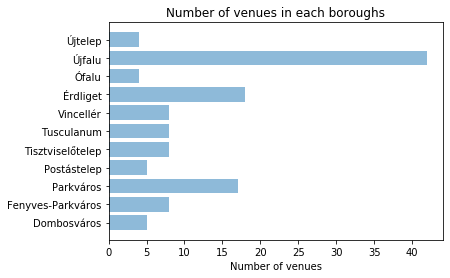

In [15]:
# let's visualize the number of venues in each neighborhood
boroughs = venue_count['Neighborhood']
category = venue_count['Venue Category']

plt.barh(boroughs, category, align='center', alpha=0.5)
plt.yticks(boroughs)
plt.xlabel('Number of venues')
plt.title('Number of venues in each boroughs')

plt.show()

As you can see in chart, that the most venue is in Újfalu, Érdliget and Parkváros - these districts are near to the railwaystation and motorway, and these are the fastest and best developing areas in Érd. The other districts have almost the same number of venues, but under 10.

Then I merged my price table with venue category to see the connection between the prices and venues.

In [16]:
import seaborn as sns

price.columns = ['Neighborhood', 'Price']
regdata = pd.merge(price, venue_count, how='left', on='Neighborhood')
regdata.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], \
             axis=1, inplace = True)
regdata

,Neighborhood,Price,Venue Category
0,Újfalu,43660,42
1,Tisztviselőtelep,54400,8
2,Újtelep,44490,4
3,Tusculanum,70960,8
4,Dombosváros,56610,5
5,Vincellér,55230,8
6,Parkváros,60460,17
7,Fenyves-Parkváros,71170,8
8,Ófalu,40140,4
9,Érdliget,63970,18


I try to find connection between the prices and the number of venues in each districts, so I use a correlation analysis for that (linear regression).

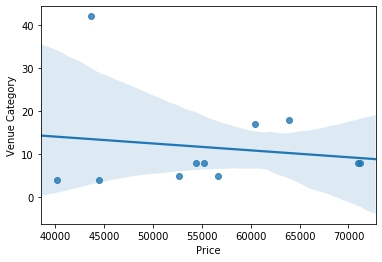

In [17]:
sns.regplot(x='Price', y='Venue Category', data=regdata)

Unfortunately the regression plot shows a weak correlation between the price and number of venues in my town. That means that for people who move into this town lots of stores or venues are not so important, this feature does not increase the housing price.

## 3.2 Clustering

In [19]:
# analyze neighborhood according to venue categories
erd_onehot = pd.get_dummies(erd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
erd_onehot['Neighborhood'] = erd_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [erd_onehot.columns[-1]] + list(erd_onehot.columns[:-1])
erd_onehot = erd_onehot[fixed_columns]

erd_onehot.head()

,Neighborhood,American Restaurant,Athletics & Sports,Bakery,Bar,Baseball Field,Basketball Stadium,Boutique,Burger Joint,Bus Station,...,Restaurant,River,Shoe Store,Smoke Shop,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Train Station
0,Újfalu,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Újfalu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Újfalu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Újfalu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Újfalu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next I searched for the 10 most common venues in each neighborhood, that is needed for clustering.

In [21]:
erd_grouped = erd_onehot.groupby('Neighborhood').mean().reset_index()

# Put the top 10 venues into dataframe

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = erd_grouped['Neighborhood']

for ind in np.arange(erd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(erd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dombosváros,Bus Stop,Bus Station,Playground,Recording Studio,Train Station,Discount Store,Eastern European Restaurant,Electronics Store,Farm,Cupcake Shop
1,Fenyves-Parkváros,American Restaurant,Bus Stop,Forest,Gym,Intersection,Pharmacy,Cupcake Shop,Fruit & Vegetable Store,Eastern European Restaurant,Athletics & Sports
2,Parkváros,Bakery,Bus Stop,Grocery Store,Pizza Place,Greek Restaurant,Garden Center,Flower Shop,Playground,Pharmacy,Food & Drink Shop
3,Postástelep,Bus Stop,Grocery Store,Bakery,Eastern European Restaurant,Train Station,Dessert Shop,Fruit & Vegetable Store,Forest,Food & Drink Shop,Food
4,Tisztviselőtelep,Stadium,Train Station,Restaurant,Food,Pool,Fruit & Vegetable Store,Bakery,Baseball Field,Dessert Shop,Forest
5,Tusculanum,Fruit & Vegetable Store,Grocery Store,Plaza,Park,Gym Pool,Gym,Restaurant,Bakery,Flower Shop,Food
6,Vincellér,Bus Stop,Greek Restaurant,Grocery Store,Sports Club,Eastern European Restaurant,Pharmacy,Farm,Dessert Shop,Discount Store,Electronics Store
7,Érdliget,Pub,Dessert Shop,Bus Stop,Train Station,Supermarket,Historic Site,Ice Cream Shop,Pizza Place,Carpet Store,Chinese Restaurant
8,Ófalu,Baseball Field,River,Farmers Market,Motel,Train Station,Cupcake Shop,Forest,Food & Drink Shop,Food,Flower Shop
9,Újfalu,Clothing Store,Gym,Shoe Store,Chinese Restaurant,Cosmetics Shop,Fast Food Restaurant,Grocery Store,Pharmacy,Supermarket,Bar


Among the most common venues we can find transport hubs, social venues as well as stores and eating places.

To cluster the town I used unsupervised machine learning technique called K-means algorithm. First I tried to find the best k velue for clustering with elbow method.

Initialization complete
Iteration  0, inertia 3.092
Iteration  1, inertia 1.442
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.149290e-07
Initialization complete
Iteration  0, inertia 2.038
Iteration  1, inertia 1.442
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.149290e-07
Initialization complete
Iteration  0, inertia 3.092
Iteration  1, inertia 1.442
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.149290e-07
Initialization complete
Iteration  0, inertia 2.738
Iteration  1, inertia 1.442
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.149290e-07
Initialization complete
Iteration  0, inertia 2.038
Iteration  1, inertia 1.442
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.149290e-07
Initialization complete
Iteration  0, inertia 3.477
Iteration  1, inertia 1.442
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.149290e-07
Initialization complete
Iter

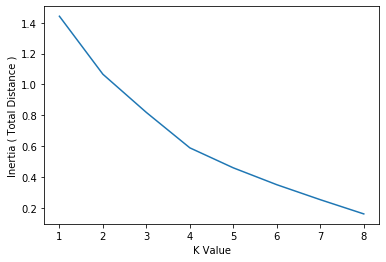

In [22]:
erd_grouped_clustering = erd_grouped.drop('Neighborhood', 1)

def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2).fit(erd_grouped_clustering)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n

variances,K,n=cluster_variance(8)

plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

The plot shows me that there is no sharp shift in the line, but there are two breakings at 2 and 4 K value. 2 is two small value for clustering, so I chose the value 4 for K-means clustering.

In [23]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(erd_grouped_clustering)
kmeans.labels_[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 2, 0])

Finally I merged the origin boroughs-price table with the table cointains the most common venues. 
The new table also contains the cluster labels, so we can see which neighborhood belongs to wich cluster.

In [24]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
neighborhoods_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
erd_price.columns = ['Neighborhood', 'Price', 'Latitude', 'Longitude']
erd_merged = erd_price
erd_merged = erd_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
erd_merged

,Neighborhood,Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Újfalu,43660,47.3740,18.9268,0,Clothing Store,Gym,Shoe Store,Chinese Restaurant,Cosmetics Shop,Fast Food Restaurant,Grocery Store,Pharmacy,Supermarket,Bar
1,Tisztviselőtelep,54400,47.3686,18.9050,0,Stadium,Train Station,Restaurant,Food,Pool,Fruit & Vegetable Store,Bakery,Baseball Field,Dessert Shop,Forest
2,Újtelep,44490,47.3719,18.8881,3,Stadium,Food & Drink Shop,Food,Farm,Train Station,Cosmetics Shop,Fruit & Vegetable Store,Forest,Flower Shop,Fast Food Restaurant
3,Tusculanum,70960,47.3838,18.9093,0,Fruit & Vegetable Store,Grocery Store,Plaza,Park,Gym Pool,Gym,Restaurant,Bakery,Flower Shop,Food
4,Dombosváros,56610,47.3940,18.8888,1,Bus Stop,Bus Station,Playground,Recording Studio,Train Station,Discount Store,Eastern European Restaurant,Electronics Store,Farm,Cupcake Shop
5,Vincellér,55230,47.4006,18.9117,1,Bus Stop,Greek Restaurant,Grocery Store,Sports Club,Eastern European Restaurant,Pharmacy,Farm,Dessert Shop,Discount Store,Electronics Store
6,Parkváros,60460,47.4133,18.8960,0,Bakery,Bus Stop,Grocery Store,Pizza Place,Greek Restaurant,Garden Center,Flower Shop,Playground,Pharmacy,Food & Drink Shop
7,Fenyves-Parkváros,71170,47.4216,18.8733,0,American Restaurant,Bus Stop,Forest,Gym,Intersection,Pharmacy,Cupcake Shop,Fruit & Vegetable Store,Eastern European Restaurant,Athletics & Sports
8,Ófalu,40140,47.3617,18.9315,2,Baseball Field,River,Farmers Market,Motel,Train Station,Cupcake Shop,Forest,Food & Drink Shop,Food,Flower Shop
9,Érdliget,63970,47.3885,18.9346,0,Pub,Dessert Shop,Bus Stop,Train Station,Supermarket,Historic Site,Ice Cream Shop,Pizza Place,Carpet Store,Chinese Restaurant


As it seems from the table, most neighborhood got to cluster 0 and 1, and only one-one boroughs belong to the cluster 2 and 3. I can label the clusters according to their main content as follows:
* Cluster 0 = mainly supermarkets, shops and restaurants
* Cluster 1 = mainly traffic stations ans social venues
* Cluster 2 = sport field and nature
* Cluster 3 = small shops

# 4. Result

Finally I wanted to visualize the results of clustering, I used geolocator package for that.

In [45]:
# visualize the resulting clusters
address = 'Érd'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, pr, cluster in zip(erd_merged['Latitude'], erd_merged['Longitude'], \
                                  erd_merged['Neighborhood'], erd_merged['Price'], erd_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' ' + str(pr) + ' ' + 'Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

The markers shown that the town is divided into well-separeted groups (cluster). Cluster 0 marked by red, is located on the north of Érd and on the both side of railway, Cluster 1 is between the red points, and the remaining two clusters are the furthest parts of the town.
The label shows the name of borough, the average price and the name of cluster. 

# 5. Discussion

In this project I examined the average housing sales prices in a small town in Hungary, Érd and I tried to find connection between the prices and the venues located in the districts and its neighborhoods.

I used linear regression to find correlation between prices and the number of venues in each boroughs, but the ananlyzis showed the opposite: the number of venues does not influence the price. It is an interesting task to figure out the reasons why people move to Érd in such a big number, but I have no enough data and information to that, and it is out of scope of this study.

I used the K-means algorithm for clustering the districts. When I tested the Elbow method, I set the optimum k value to 4. All the 11 district coordinates were used in the sample. For more detailed and accurate result, the data set and the radius for searching venues can be expanded, maybe bigger k value can be used.

Finally I ended my study by visualizing the price and clustering information on the map.

# 6. Conclusion

The population of Érd grows year by year, at the same time the number of stores, restaurants and supermarkets also increase.
In the last 4 years the housing sales price has increased by almost 50%. To understand the real causes of this increasing is important for the entrepreneurs and the potential habitants, to find the right place for a new home or a new successful business. This kind of data analyzis can help to bring the supplier and the customer together.